In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print('Google Colab GPU Available')
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/drive/
Google Colab GPU Available
Tue Nov  3 08:56:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                  

In [ ]:
%cd '/content/drive/My Drive/spatial_rnn_fingernail_detection/'
!pwd

import sys
sys.path.append('/content/drive/My Drive/spatial_rnn_fingernail_detection/')
sys.path.append('/content/drive/My Drive/spatial_rnn_fingernail_detection/src/')
sys.path.append('/content/drive/My Drive/spatial_rnn_fingernail_detection/src/models')
sys.path.append('/content/drive/My Drive/spatial_rnn_fingernail_detection/src/model_dev')

/content/drive/My Drive/spatial_rnn_fingernail_detection
/content/drive/My Drive/spatial_rnn_fingernail_detection


In [ ]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from src.models.loss.loss import bce_dice_loss, dice_coefficient, dice_metric
from src.utils.utility_functions import *
from src.models.network.Unet2D import unet2d_8_128
from src.models.network.Unet2DResidual import unet2d_res_32_512
from src.models.network.Unet2DResidualRnn import unet2D_res_srnn_32_512
from src.models.network.Unet2DResidualRnnSmall import unet2D_res_srnn_8_128

In [ ]:
import keras
from IPython.display import clear_output


class PlotLearning(keras.callbacks.Callback):
    """
    Callback function for plotting the training results at the end of each epoch.
    """
    def __init__(self, train_object):
        self.training = train_object
        super(PlotLearning, self).__init__()

    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_metric'))
        self.val_acc.append(logs.get('val_dice_metric'))

        fig, ax1 = plt.subplots(figsize=(10, 5))
        clear_output(wait=True)
        lns1 = ax1.plot(self.x, self.acc, label="Train Dice Score", color='orange', linewidth=2.)
        lns2 = ax1.plot(self.x, self.val_acc, label="Test Dice Score", color='blue', linewidth=2.)
        ax1.set_ylabel('Dice Score', fontsize=15)
        ax1.set_xlabel('Epoch', fontsize=15)
        ax1.set_title(self.training.RUN_ID)
        ax2 = ax1.twinx()
        lns3 = ax2.plot(self.x, self.losses, '--', label="Train Loss", color='orange')
        lns4 = ax2.plot(self.x, self.val_losses, '--', label="Test Loss", color='blue')
        ax2.set_ylabel('Loss', fontsize=15)
        lns = lns1 + lns2 + lns3 + lns4
        ax1.legend(lns, [l.get_label() for l in lns])
        ax1.grid(True)
        plt.xlim([-0.05, epoch + .05])
        plt.show()

In [ ]:
tf.compat.v1.disable_eager_execution()
np.random.seed(144)
tf.random.set_seed(144)
K.set_image_data_format('channels_last')


class TPEFingernail:
    def __init__(self, model_class, x_train, y_train, x_test, y_test, **kwargs):
        self.STUDY_NAME = kwargs.get('run_name', 'Fingernail_dataset1')
        self.TO_SAVE = True
        self.VERBOSE = 0

        self.IMAGE_DATA_TYPE = np.int16
        self.IMG_ROWS = 160
        self.IMG_COLS = 192
        self.IMG_CHNS = 3

        self.TEST_RATIO = 0.08
        self.BATCH_SIZE = 2
        self.EPOCH = 220

        self.IMAGE_RAW_DATA_FOLDER = 'data/label/image/'
        self.LABEL_RAW_DATA_FOLDER = 'data/label/label/'
        self.SAVED_MODEL_FOLDER = 'model/weight/'
        self.SAVED_LOGS_FOLDER = 'model/log/'
        self.SAVED_RESULTS_FOLDER = 'model/prediction/'
        check_exist_folder(self.SAVED_MODEL_FOLDER, create_if_not_exist=True)
        check_exist_folder(self.SAVED_LOGS_FOLDER, create_if_not_exist=True)
        check_exist_folder(self.SAVED_RESULTS_FOLDER, create_if_not_exist=True)

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.y_pred = None
        self.model_class = model_class
        self.model = model_class(img_rows=self.IMG_ROWS, img_cols=self.IMG_COLS, img_chns=self.IMG_CHNS)

        self.optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199, name='AdamLR-5')
        self.loss = bce_dice_loss
        self.loss_name = 'DICE'
        self.metrics = [dice_metric]
        self.make_run_id()

    def make_run_id(self):
        self.RUN_ID = '%s_%s_%s_EP%d_BS%d_%dx%d' % (self.STUDY_NAME, self.model.name, self.loss_name, self.EPOCH,
                                                    self.BATCH_SIZE, self.IMG_ROWS, self.IMG_COLS)

    def set_img_size(self, img_rows, img_cols):
        self.IMG_ROWS = img_rows
        self.IMG_COLS = img_cols
        self.model = self.model_class(img_rows=self.IMG_ROWS, img_cols=self.IMG_COLS, img_chns=self.IMG_CHNS)
        self.make_run_id()
        return self

    def change_model(self, model_class):
        self.model = model_class(img_rows=self.IMG_ROWS, img_cols=self.IMG_COLS, img_chns=self.IMG_CHNS)
        self.make_run_id()
        return self

    def set_run_name(self, run_name):
        self.STUDY_NAME = run_name
        self.make_run_id()
        return self

    def set_num_epochs(self, new_epochs):
        self.EPOCH = new_epochs
        self.make_run_id()
        return self

    def set_batch_size(self, new_batch_size):
        self.BATCH_SIZE = new_batch_size
        self.make_run_id()
        return self

    def set_optimizer(self, optimizer_inp):
        self.optimizer = optimizer_inp
        return self

    def set_loss(self, loss, loss_name):
        self.loss = loss
        self.loss_name = loss_name
        self.make_run_id()
        return self

    def set_metrics(self, metrics_inp):
        self.metrics = metrics_inp
        return self

    def train(self, **kwargs):
        run_id = kwargs.get('run_id', self.RUN_ID)
        to_save = kwargs.get('to_save', self.TO_SAVE)
        x_test = kwargs.get('x_test', self.x_test)
        y_test = kwargs.get('y_test', self.y_test)
        x_train = kwargs.get('x_train', self.x_train)
        y_train = kwargs.get('y_train', self.y_train)

        print('_' * 70 + '\nTrain process started on train/test %s/%s.' %(str(x_train.shape),str(y_train.shape)))

        print('_' * 70 + '\nCreating and compiling model...')
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        callbacks = self.get_callbacks()

        print('_' * 70 + '\nFitting model...')
        if x_test is not None:
            train_history = self.model.fit(self.x_train, self.y_train, batch_size=self.BATCH_SIZE,
                                           epochs=self.EPOCH, verbose=self.VERBOSE, shuffle=False,
                                           validation_data=(x_test, y_test), callbacks=callbacks)
        else:
            train_history = self.model.fit(self.x_train, self.y_train, batch_size=self.BATCH_SIZE,
                                           epochs=self.EPOCH, verbose=self.VERBOSE, shuffle=False,
                                           validation_split=self.TEST_RATIO, callbacks=callbacks)
        self.train_hist_df = pd.DataFrame(train_history.history, index=train_history.epoch)
        print('_' * 70 + '\nTraining finished')

        if to_save:
            if not os.path.exists(self.SAVED_MODEL_FOLDER):
                os.mkdir(self.SAVED_MODEL_FOLDER)
            model_weights_addr = os.path.join(self.SAVED_MODEL_FOLDER, run_id + '_best_weights.h5')
            # self.model.save_weights(model_weights_addr)
            print('Best weights saved at %s.' % model_weights_addr)

            train_history_addr = os.path.join(self.SAVED_LOGS_FOLDER, run_id + 'train_history.csv')
            self.train_hist_df.to_csv(path_or_buf=train_history_addr)
            print('Train history saved at %s.' % train_history_addr)
        self.train_res_dic = {'model': self.model, 'train_history': train_history}
        return self.train_res_dic

    def predict(self, x_test=None, y_test=None, **kwargs):
        to_save = kwargs.get('to_save', self.TO_SAVE)
        run_id = kwargs.get('run_id', self.RUN_ID)
        if x_test is None or y_test is None:
            x_test = self.x_test
            y_test = self.y_test
        self.y_pred = self.model.predict(self.x_test, batch_size=self.BATCH_SIZE, verbose=self.VERBOSE)
        print('_' * 70 + '\nPrediction on test data shape %s output shape %s.' %(self.x_test.shape,self.y_pred.shape))

        if to_save:
            if not os.path.exists(self.SAVED_RESULTS_FOLDER):
                os.mkdir(self.SAVED_RESULTS_FOLDER)
            np.save(os.path.join(self.SAVED_RESULTS_FOLDER, run_id + '_test_feature.npy'), self.x_test)
            np.save(os.path.join(self.SAVED_RESULTS_FOLDER, run_id + '_test_label.npy'), self.y_test)
            np.save(os.path.join(self.SAVED_RESULTS_FOLDER, run_id + '_test_predict.npy'), self.y_pred)
            print('Predicted label saved to ' + os.path.join(self.SAVED_RESULTS_FOLDER,
                                                             run_id + '_test_predict.npy'))
        self.pred_res_dic = {'x_test': x_test, 'y_test': y_test, 'y_pred': self.y_pred}
        return self.pred_res_dic

    def evaluate(self, y_test=None, y_pred=None, is_plot=False):
        if y_test is None or y_pred is None:
            y_test = self.y_test
            y_pred = self.y_pred
        evaluation_res = dice_coefficient(y_test, y_pred)

        if is_plot:
            fig, axs = plt.subplots(2, 2)
            axs[0, 0].imshow(y_test[0, :, :, 0])
            axs[0, 0].set_title('Test Label')
            axs[0, 0].get_xaxis().set_visible(False)

            axs[0, 1].imshow(y_pred[0, :, :, 0])
            axs[0, 1].set_title('Test Pred')
            axs[0, 1].get_xaxis().set_visible(False)

            axs[1, 0].imshow(y_test[-1, :, :, 0])
            axs[1, 0].set_title('Test Label')
            axs[1, 0].get_xaxis().set_visible(False)

            axs[1, 1].imshow(y_pred[-1, :, :, 0])
            axs[1, 1].set_title('Test Pred')
            axs[1, 1].get_xaxis().set_visible(False)
            plt.show()
        print('Dice score accuracy on test dataset is %f02' % evaluation_res)
        return evaluation_res

    def get_callbacks(self):
        plot_learning = PlotLearning(train_object=self)
        model_checkpoint = ModelCheckpoint(os.path.join(self.SAVED_MODEL_FOLDER, self.RUN_ID + '_best_weights.h5'),
                                           monitor='val_dice_metric', mode= 'max',save_best_only=True, save_weights_only=True)
        # stop_train = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001)
        if not os.path.exists(self.SAVED_LOGS_FOLDER):
            os.mkdir(self.SAVED_LOGS_FOLDER)
        csv_logger = CSVLogger(os.path.join(self.SAVED_LOGS_FOLDER, self.RUN_ID + 'train_logs.txt'), separator=',',
                               append=False)
        return [model_checkpoint, reduce_lr, csv_logger, plot_learning]

    def tpe_main(self, **kwargs):
        self.train(**kwargs)
        self.predict(**kwargs)
        self.evaluate(is_plot=True)
        # self.plot_train_hist()
        print(self.RUN_ID + '**Completed**')

    def plot_train_hist(self):
        ax = self.train_hist_df.plot(y=['loss', 'val_loss', 'dice_metric', 'val_dice_metric'], grid=True,
                                     secondary_y=['dice_metric', 'val_dice_metric'], title=self.RUN_ID)
        ax.set_xlabel('Epoch #')
        ax.set_ylabel('Loss Value')
        ax.right_ax.set_ylabel('Dice Score')
        plt.show()


def load_image_data_2(folder_path, resize_row=None, resize_col=None, test_ratio=None, data_type='float32'):
    x = []
    y = []
    image_file_mat = [f for f in os.listdir(os.path.join(folder_path, 'image')) if
                      os.path.isfile(os.path.join(folder_path, 'image', f))]
    mask_file_mat = [f for f in os.listdir(os.path.join(folder_path, 'mask')) if
                     os.path.isfile(os.path.join(folder_path, 'mask', f))]
    files = list(set(image_file_mat).intersection(set(mask_file_mat)))
    for f in files:
        image_pil = Image.open(os.path.join(folder_path, 'image', f))
        mask_pil = Image.open(os.path.join(folder_path, 'mask', f))
        mask_pil = mask_pil.convert(mode='1')
        if image_pil.size[0] < image_pil.size[1]:
            image_pil = image_pil.rotate(90, expand=True)
            mask_pil = mask_pil.rotate(90, expand=True)
        if resize_row is not None and resize_col is not None:
            image = np.array(image_pil.resize((resize_col, resize_row)))
            mask = np.array(mask_pil.resize((resize_col, resize_row)))
        else:
            image = np.array(image_pil).astype(data_type)
            mask = np.array(mask_pil).astype(data_type)
        x.append(image)
        y.append(mask)
    x = np.array(x).astype(data_type)
    x = x / 255
    y = np.array(y).astype(data_type)
    y = np.expand_dims(y, -1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio)
    print('Train image dataset shape: %s' % str(x_train.shape))
    print('Train label dataset shape: %s' % str(y_train.shape))
    print('Test image dataset shape: %s' % str(x_test.shape))
    print('Test label dataset shape: %s' % str(y_test.shape))
    print('-' * 70)
    return {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}


def load_image_data_1(folder_path, resize_row=None, resize_col=None, test_ratio=None, data_type='float32'):
    mask_files = os.listdir(os.path.join(folder_path, 'mask'))
    raw_files = os.listdir(os.path.join(folder_path, 'image'))
    # find intersection of two lists
    files = list(set(raw_files).intersection(mask_files))
    test_files = list(set(mask_files).symmetric_difference(raw_files))
    x_train = []
    x_test = []
    y_train = []
    for f in files:
        mask = Image.open(os.path.join(folder_path, 'mask', f))
        mask = np.array(mask.resize((resize_col, resize_row)))
        mask = mask.mean(axis=2)
        mask[mask < 250] = 0
        mask[mask > 0] = 1
        if not mask.sum():
            continue
        y_train.append(mask)
        raw = Image.open(os.path.join(folder_path, 'image', f))
        raw = np.array(raw.resize((resize_col, resize_row)))
        x_train.append(raw)
    for f in test_files:
        try:
            raw = Image.open(os.path.join(folder_path, 'image', f))
        except:
            continue
        raw = np.array(raw.resize((resize_col, resize_row)))
        x_test.append(raw)
    x_train = np.array(x_train).astype(data_type)
    x_train /= 255
    x_test = np.array(x_test).astype(data_type)
    x_test /= 255
    y_train = np.array(y_train)
    y_train = np.expand_dims(y_train, 3)

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_ratio)
    print('Train image dataset shape: %s' % str(x_train.shape))
    print('Train label dataset shape: %s' % str(y_train.shape))
    print('Test image dataset shape: %s' % str(x_test.shape))
    print('Test label dataset shape: %s' % str(y_test.shape))
    print('-' * 70)
    return {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}


In [ ]:
IMG_ROWS = 160
IMG_COLS = 192
print('Loading and pre_processing train data...')
data_dic_1 = load_image_data_1('data/raw/dataset1/', resize_row=IMG_ROWS,  resize_col=IMG_COLS, test_ratio=0.1)
data_dic_2 = load_image_data_2('data/raw/dataset2/', resize_row=IMG_ROWS, resize_col=IMG_COLS, test_ratio=0.1)
for key, val in data_dic_2.items():
    data_dic_2[key] = np.concatenate((data_dic_1[key], data_dic_2[key]), axis=0)

Loading and pre_processing train data...
Train image dataset shape: (172, 160, 192, 3)
Train label dataset shape: (172, 160, 192, 1)
Test image dataset shape: (20, 160, 192, 3)
Test label dataset shape: (20, 160, 192, 1)
----------------------------------------------------------------------
Train image dataset shape: (46, 160, 192, 3)
Train label dataset shape: (46, 160, 192, 1)
Test image dataset shape: (6, 160, 192, 3)
Test label dataset shape: (6, 160, 192, 1)
----------------------------------------------------------------------


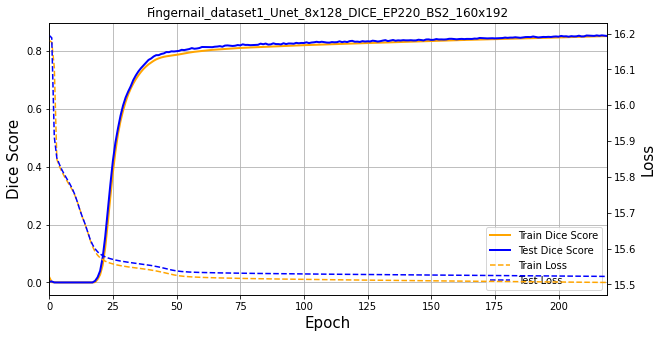

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_8x128_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_8x128_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_8x128_DICE_EP220_BS2_160x192_test_predict.npy


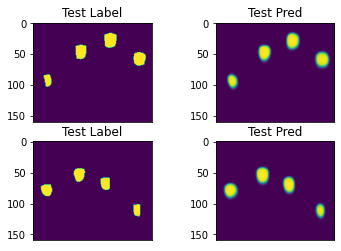

Dice score accuracy on test dataset is 0.82073302
Fingernail_dataset1_Unet_8x128_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_dice = TPEFingernail(**data_dic_1, model_class=unet2d_8_128)
train_test_eval_unet2d_dice.tpe_main()

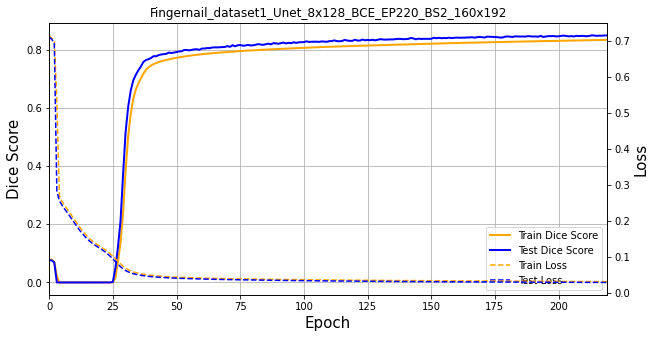

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_8x128_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_8x128_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_8x128_BCE_EP220_BS2_160x192_test_predict.npy


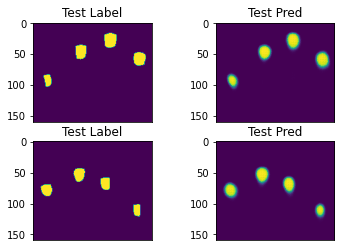

Dice score accuracy on test dataset is 0.83541302
Fingernail_dataset1_Unet_8x128_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_bce = TPEFingernail(**data_dic_1, model_class=unet2d_8_128).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_bce.tpe_main()

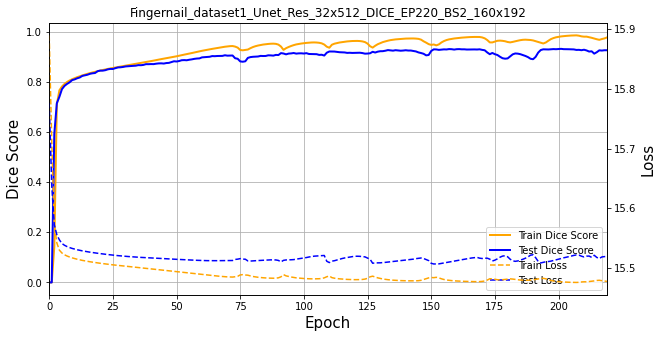

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_Res_32x512_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_Res_32x512_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_Res_32x512_DICE_EP220_BS2_160x192_test_predict.npy


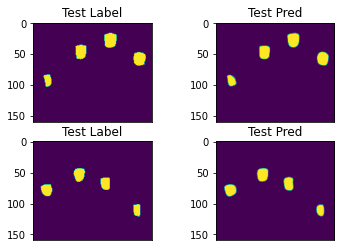

Dice score accuracy on test dataset is 0.92704502
Fingernail_dataset1_Unet_Res_32x512_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_dice = TPEFingernail(**data_dic_1, model_class=unet2d_res_32_512)
train_test_eval_unet2d_res_dice.tpe_main()

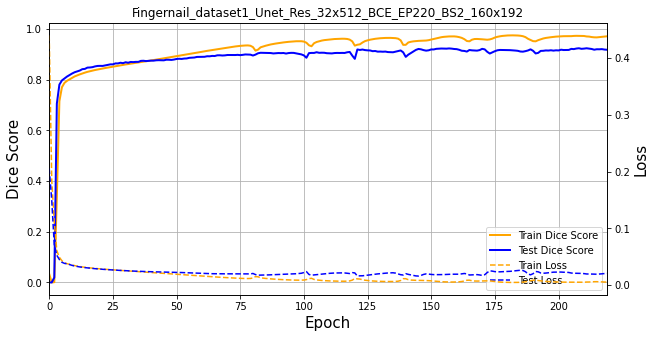

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_Res_32x512_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_Res_32x512_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_Res_32x512_BCE_EP220_BS2_160x192_test_predict.npy


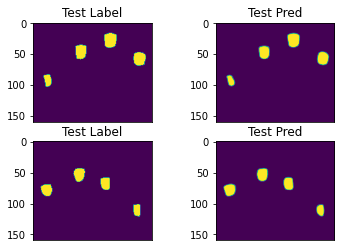

Dice score accuracy on test dataset is 0.92249202
Fingernail_dataset1_Unet_Res_32x512_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_bce = TPEFingernail(**data_dic_1, model_class=unet2d_res_32_512).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_bce.tpe_main()

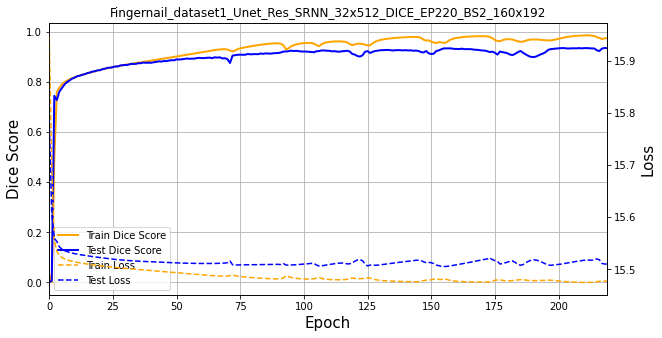

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192_test_predict.npy


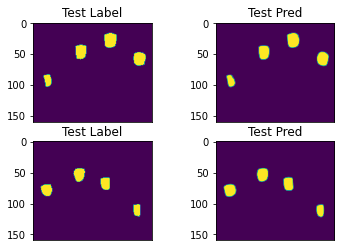

Dice score accuracy on test dataset is 0.93268002
Fingernail_dataset1_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn_dice = TPEFingernail(**data_dic_1, model_class=unet2D_res_srnn_32_512)
train_test_eval_unet2d_res_srnn_dice.tpe_main()

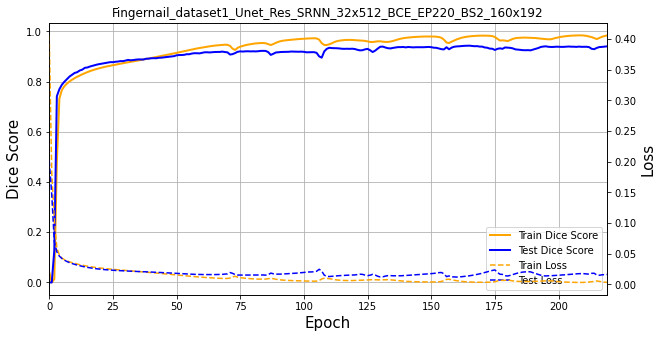

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192_test_predict.npy


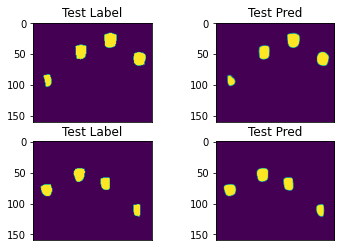

Dice score accuracy on test dataset is 0.93862102
Fingernail_dataset1_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn_bce = TPEFingernail(**data_dic_1, model_class=unet2D_res_srnn_32_512).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_srnn_bce.tpe_main()

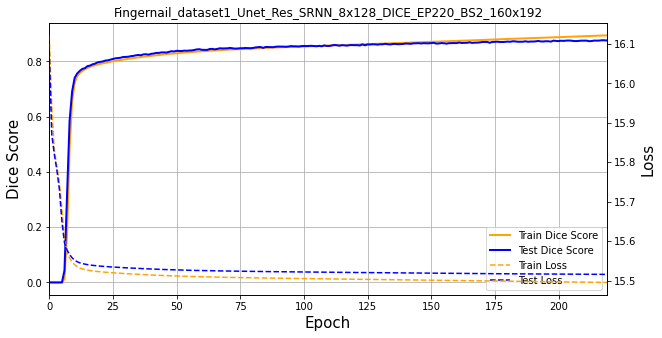

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192_test_predict.npy


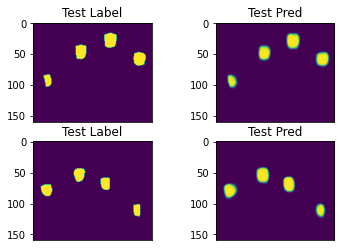

Dice score accuracy on test dataset is 0.85274802
Fingernail_dataset1_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn8_dice = TPEFingernail(**data_dic_1, model_class=unet2D_res_srnn_8_128)
train_test_eval_unet2d_res_srnn8_dice.tpe_main()

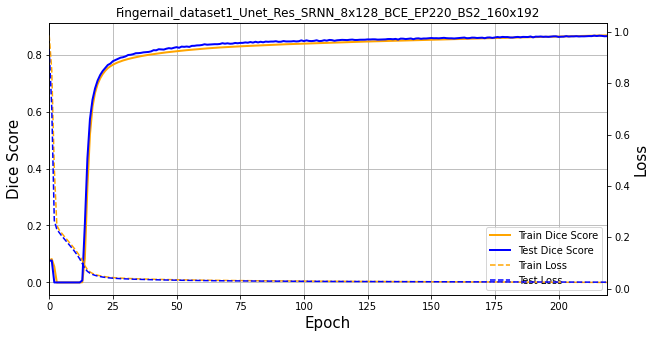

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset1_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset1_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (20, 160, 192, 3) output shape (20, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset1_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192_test_predict.npy


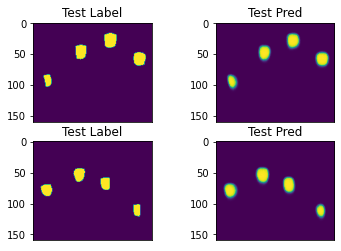

Dice score accuracy on test dataset is 0.84814502
Fingernail_dataset1_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn8_bce = TPEFingernail(**data_dic_1, model_class=unet2D_res_srnn_8_128).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_srnn8_bce.tpe_main()

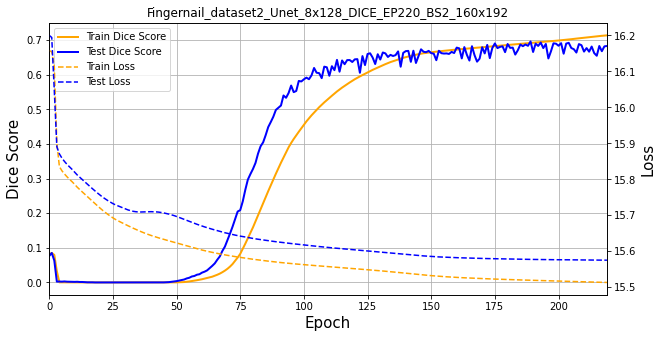

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_160x192_test_predict.npy


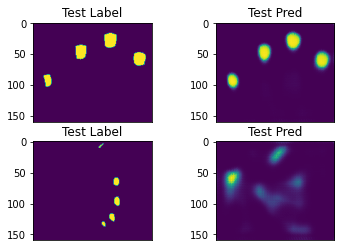

Dice score accuracy on test dataset is 0.60598302
Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_dice = TPEFingernail(**data_dic_2, model_class=unet2d_8_128, run_name='Fingernail_dataset2')
train_test_eval_unet2d_dice.tpe_main()

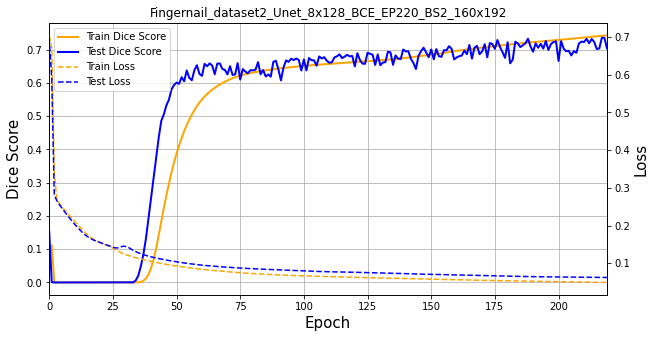

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_160x192_test_predict.npy


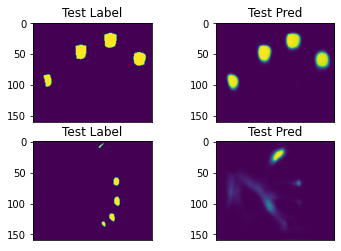

Dice score accuracy on test dataset is 0.70153202
Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_bce = TPEFingernail(**data_dic_2, model_class=unet2d_8_128, run_name='Fingernail_dataset2').set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_bce.tpe_main()

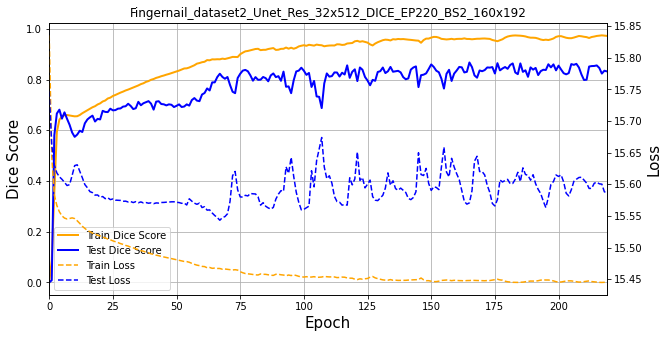

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_160x192_test_predict.npy


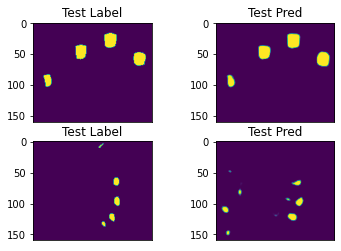

Dice score accuracy on test dataset is 0.84050402
Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_dice = TPEFingernail(**data_dic_2, model_class=unet2d_res_32_512, run_name='Fingernail_dataset2')
train_test_eval_unet2d_res_dice.tpe_main()

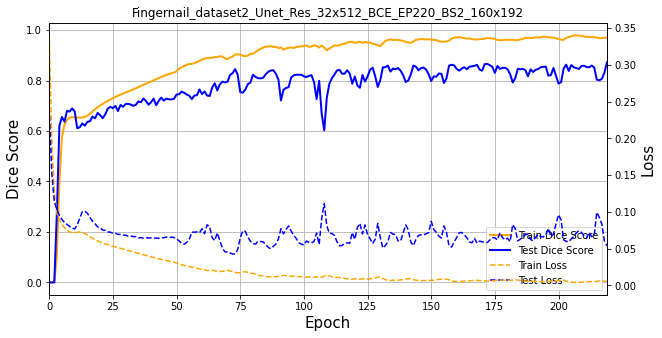

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_160x192_test_predict.npy


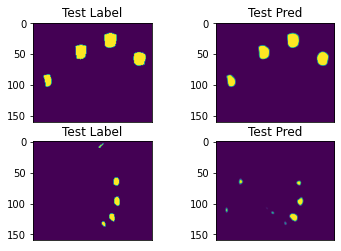

Dice score accuracy on test dataset is 0.86659302
Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_bce = TPEFingernail(**data_dic_2, model_class=unet2d_res_32_512, run_name='Fingernail_dataset2').set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_bce.tpe_main()

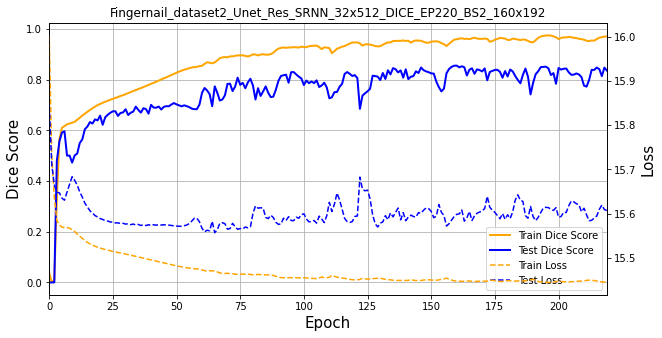

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192_test_predict.npy


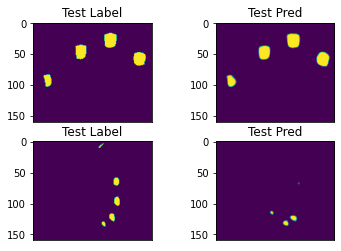

Dice score accuracy on test dataset is 0.83024202
Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn_dice = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_32_512, run_name='Fingernail_dataset2')
train_test_eval_unet2d_res_srnn_dice.tpe_main()

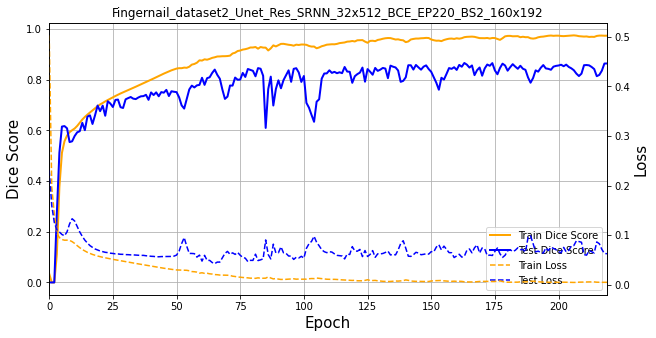

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192_test_predict.npy


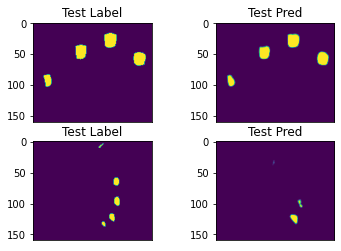

Dice score accuracy on test dataset is 0.86581402
Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn_bce = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_32_512, run_name='Fingernail_dataset2').set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_srnn_bce.tpe_main()

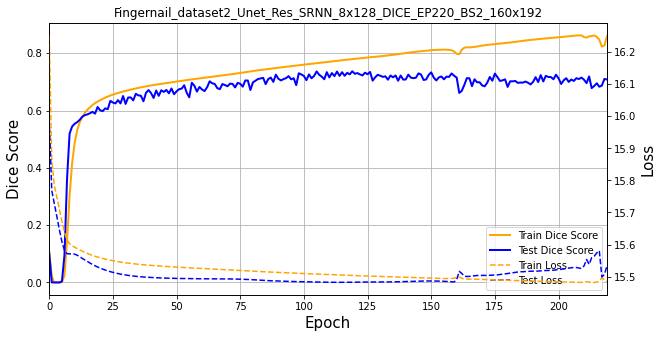

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192_test_predict.npy


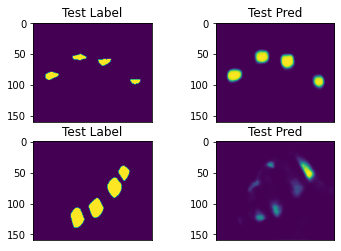

Dice score accuracy on test dataset is 0.70623502
Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn8_dice = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_8_128, run_name='Fingernail_dataset2')
train_test_eval_unet2d_res_srnn8_dice.tpe_main()

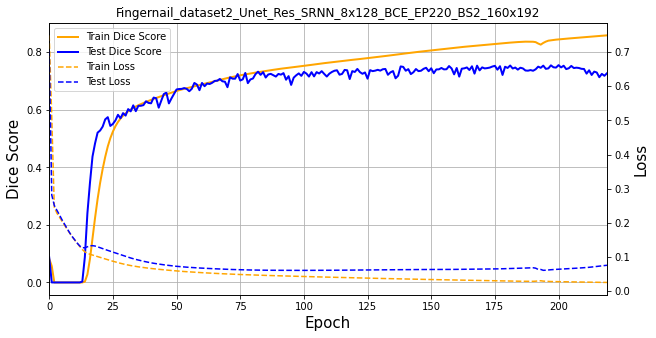

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192_test_predict.npy


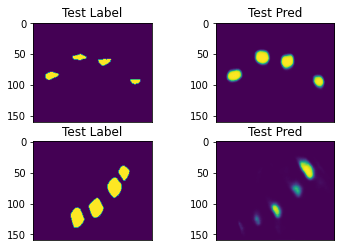

Dice score accuracy on test dataset is 0.73928102
Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn8_bce = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_8_128, run_name='Fingernail_dataset2').set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_srnn8_bce.tpe_main()

In [ ]:
IMG_ROWS = 320
IMG_COLS = 384
print('Loading and pre_processing train data...')
data_dic_1 = load_image_data_1('data/raw/dataset1/', resize_row=IMG_ROWS,  resize_col=IMG_COLS, test_ratio=0.1)
data_dic_2 = load_image_data_2('data/raw/dataset2/', resize_row=IMG_ROWS, resize_col=IMG_COLS, test_ratio=0.1)
for key, val in data_dic_2.items():
    data_dic_2[key] = np.concatenate((data_dic_1[key], data_dic_2[key]), axis=0)

Loading and pre_processing train data...
Train image dataset shape: (172, 320, 384, 3)
Train label dataset shape: (172, 320, 384, 1)
Test image dataset shape: (20, 320, 384, 3)
Test label dataset shape: (20, 320, 384, 1)
----------------------------------------------------------------------
Train image dataset shape: (46, 320, 384, 3)
Train label dataset shape: (46, 320, 384, 1)
Test image dataset shape: (6, 320, 384, 3)
Test label dataset shape: (6, 320, 384, 1)
----------------------------------------------------------------------


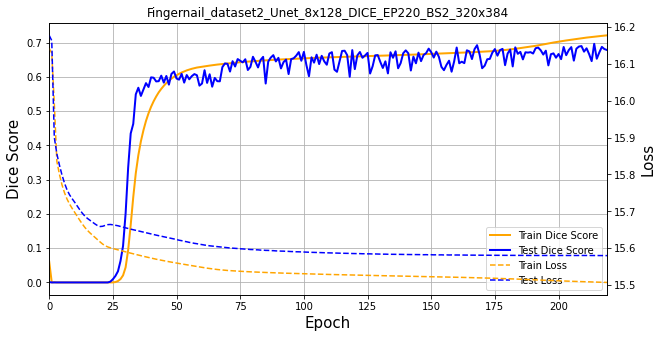

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_320x384_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_320x384train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 320, 384, 3) output shape (26, 320, 384, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_320x384_test_predict.npy


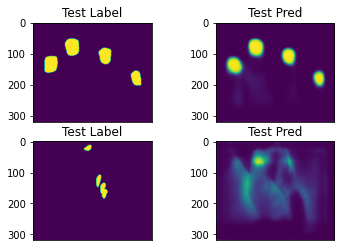

Dice score accuracy on test dataset is 0.63461102
Fingernail_dataset2_Unet_8x128_DICE_EP220_BS2_320x384**Completed**


In [ ]:
train_test_eval_unet2d_dice = TPEFingernail(**data_dic_2, model_class=unet2d_8_128, run_name='Fingernail_dataset2').set_img_size(320,384)
train_test_eval_unet2d_dice.tpe_main()

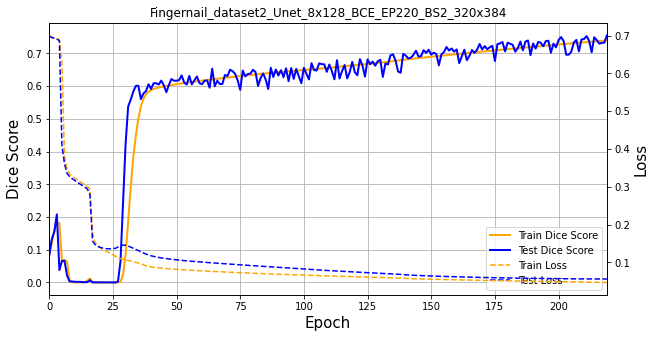

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_320x384_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_320x384train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 320, 384, 3) output shape (26, 320, 384, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_320x384_test_predict.npy


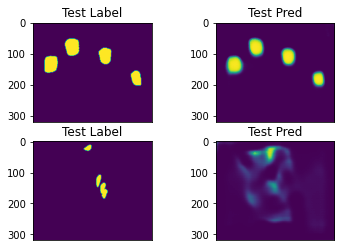

Dice score accuracy on test dataset is 0.72457702
Fingernail_dataset2_Unet_8x128_BCE_EP220_BS2_320x384**Completed**


In [ ]:
train_test_eval_unet2d_bce = TPEFingernail(**data_dic_2, model_class=unet2d_8_128, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_bce.tpe_main()


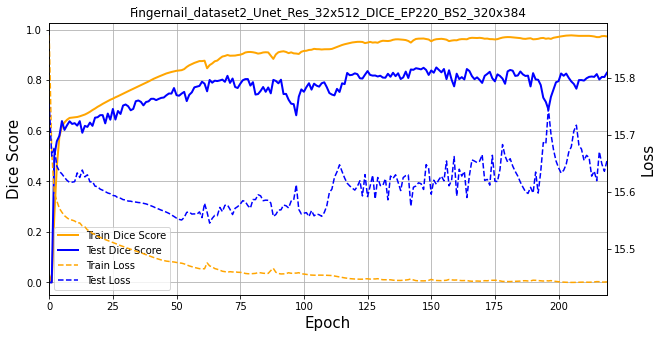

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_320x384_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_320x384train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 320, 384, 3) output shape (26, 320, 384, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_320x384_test_predict.npy


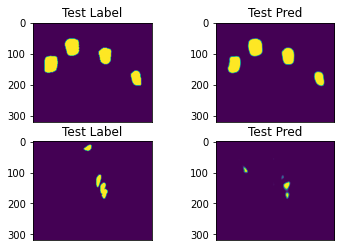

Dice score accuracy on test dataset is 0.83095902
Fingernail_dataset2_Unet_Res_32x512_DICE_EP220_BS2_320x384**Completed**


In [ ]:
train_test_eval_unet2d_res_dice = TPEFingernail(**data_dic_2, model_class=unet2d_res_32_512, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS)
train_test_eval_unet2d_res_dice.tpe_main()

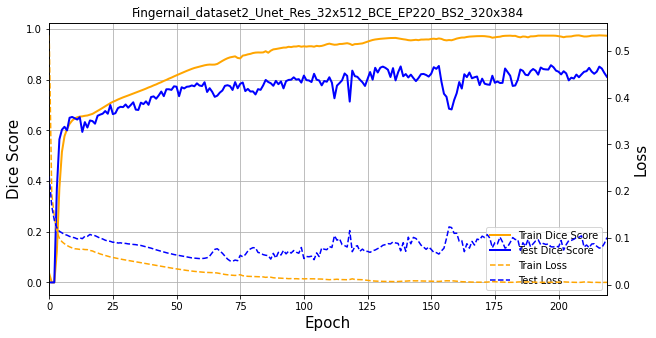

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_320x384_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_320x384train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 320, 384, 3) output shape (26, 320, 384, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_320x384_test_predict.npy


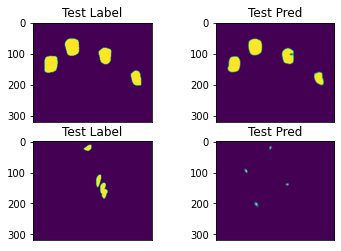

Dice score accuracy on test dataset is 0.81635302
Fingernail_dataset2_Unet_Res_32x512_BCE_EP220_BS2_320x384**Completed**


In [ ]:
train_test_eval_unet2d_res_bce = TPEFingernail(**data_dic_2, model_class=unet2d_res_32_512, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_bce.tpe_main()


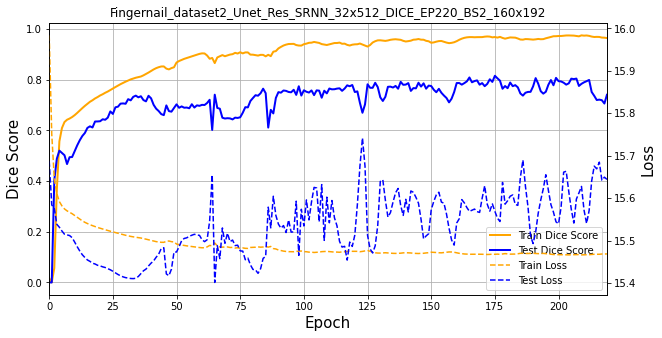

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192_test_predict.npy


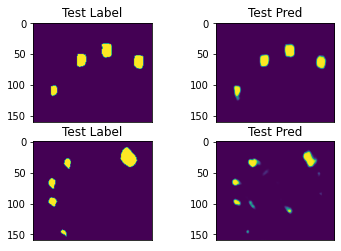

Dice score accuracy on test dataset is 0.72201102
Fingernail_dataset2_Unet_Res_SRNN_32x512_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn_dice = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_32_512, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS)
train_test_eval_unet2d_res_srnn_dice.tpe_main()

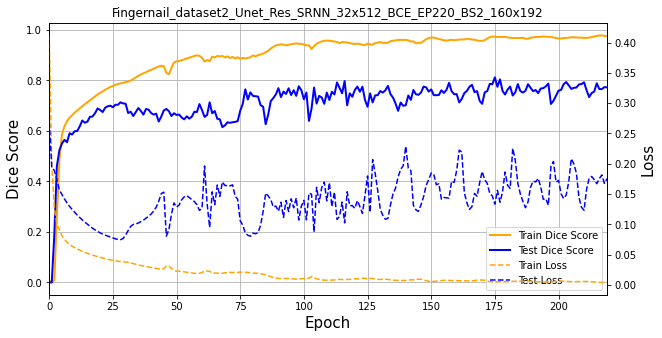

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192_test_predict.npy


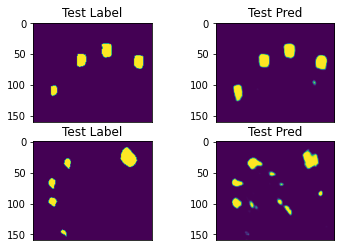

Dice score accuracy on test dataset is 0.75114502
Fingernail_dataset2_Unet_Res_SRNN_32x512_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn_bce = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_32_512, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_srnn_bce.tpe_main()


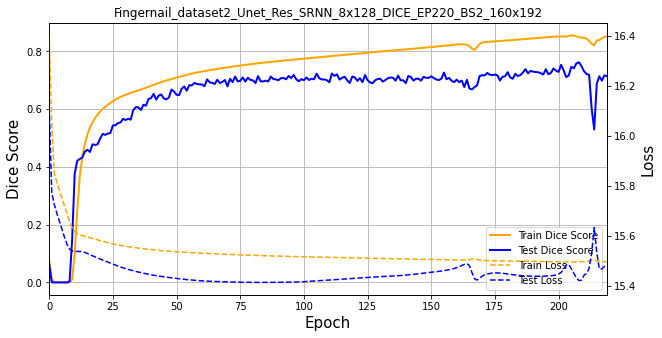

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192_test_predict.npy


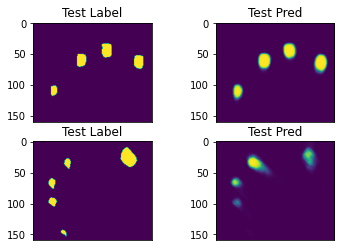

Dice score accuracy on test dataset is 0.68477302
Fingernail_dataset2_Unet_Res_SRNN_8x128_DICE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn8_dice = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_8_128, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS)
train_test_eval_unet2d_res_srnn8_dice.tpe_main()

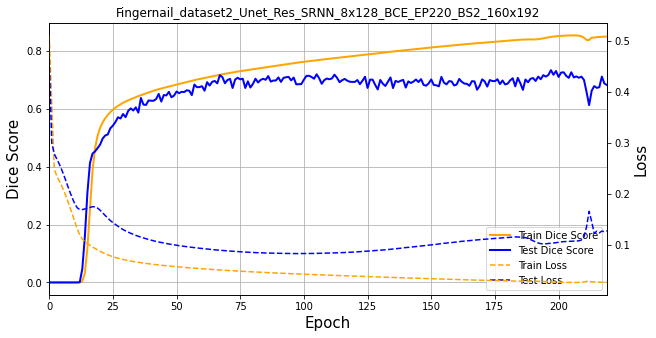

______________________________________________________________________
Training finished
Best weights saved at model/weight/Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192_best_weights.h5.
Train history saved at model/log/Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192train_history.csv.
______________________________________________________________________
Prediction on test data shape (26, 160, 192, 3) output shape (26, 160, 192, 1).
Predicted label saved to model/prediction/Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192_test_predict.npy


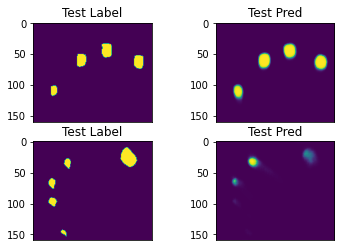

Dice score accuracy on test dataset is 0.67434402
Fingernail_dataset2_Unet_Res_SRNN_8x128_BCE_EP220_BS2_160x192**Completed**


In [ ]:
train_test_eval_unet2d_res_srnn8_bce = TPEFingernail(**data_dic_2, model_class=unet2D_res_srnn_8_128, run_name='Fingernail_dataset2').set_img_size(IMG_ROWS,IMG_COLS).set_loss(loss=binary_crossentropy, loss_name='BCE')
train_test_eval_unet2d_res_srnn8_bce.tpe_main()